In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import datetime

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

In [2]:
RANDOM_SEED = 42

In [3]:
df_train = pd.read_csv('data/main_task.csv')
df_test = pd.read_csv('data/kaggle_task.csv')

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [4]:
df_preproc = data.copy()


In [5]:
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
data['Cuisine_Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')
# data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')

In [6]:
df_preproc['Number of Reviews'].fillna(0, inplace=True)
df_preproc['Cuisine Style'].fillna(0, inplace=True)


In [7]:
df_preproc['Cuisine Style']

0                                           ['Bar', 'Pub']
1        ['European', 'Scandinavian', 'Gluten Free Opti...
2                                  ['Vegetarian Friendly']
3        ['Italian', 'Mediterranean', 'European', 'Vege...
4        ['Italian', 'Mediterranean', 'European', 'Seaf...
                               ...                        
49995    ['Italian', 'Vegetarian Friendly', 'Vegan Opti...
49996    ['French', 'American', 'Bar', 'European', 'Veg...
49997                                ['Japanese', 'Sushi']
49998    ['Polish', 'European', 'Eastern European', 'Ce...
49999                                          ['Spanish']
Name: Cuisine Style, Length: 50000, dtype: object

In [8]:
df_preproc['Cuisine Style'] = df_preproc['Cuisine Style'].str[2:-2].str.split("', '")

In [9]:
df_preproc

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5
49996,id_6340,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5
49997,id_1649,Stockholm,"[Japanese, Sushi]",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5
49998,id_640,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0


In [10]:
def price_range_rating (price_range_string):
    if "$$$$" in str(price_range_string):
        return 3
    elif "$$ - $$$" in str(price_range_string):
        return 2
    elif "$" in str(price_range_string):
        return 1
    elif str(0) in str(price_range_string):
        return 0

df_preproc['Price Range'] = df_preproc['Price Range'].apply(price_range_rating)
#Делаем dummies на основе изменного Price Range
df_preproc = pd.get_dummies(df_preproc, columns=['Price Range', ], dummy_na=True)

In [11]:
population = {
    'London': 8908081,
    'Paris': 2240621,
    'Madrid': 3155360,
    'Barcelona': 1593075,
    'Berlin': 3326002,
    'Milan': 1331586,
    'Rome': 2870493,
    'Prague': 1272690,
    'Lisbon': 547733,
    'Vienna': 1765649,
    'Amsterdam': 825080,
    'Brussels': 144784,
    'Hamburg': 1718187,
    'Munich': 1364920,
    'Lyon': 496343,
    'Stockholm': 1981263,
    'Budapest': 1744665,
    'Warsaw': 1720398,
    'Dublin': 506211 ,
    'Copenhagen': 1246611,
    'Athens': 3168846,
    'Edinburgh': 476100,
    'Zurich': 402275,
    'Oporto': 221800,
    'Geneva': 196150,
    'Krakow': 756183,
    'Oslo': 673469,
    'Helsinki': 574579,
    'Bratislava': 413192,
    'Luxembourg': 576249,
    'Ljubljana': 277554
}
df_preproc['Population'] = df_preproc['City'].map(population)

In [12]:
count = df_preproc['City'].value_counts()
df_preproc['restaurant_in_city'] = df_preproc['City'].apply(lambda x : count[x])

In [13]:
# Добавляем новый признак "Столица - Не столица"
capitals = {'City': [
    'London', 'Paris', 'Madrid', 'Barcelona', 'Berlin', 'Milan', 'Rome', 'Prague',
    'Lisbon', 'Vienna', 'Amsterdam', 'Brussels', 'Hamburg', 'Munich', 'Lyon', 'Stockholm',
    'Budapest', 'Warsaw', 'Dublin', 'Copenhagen', 'Athens', 'Edinburgh', 'Zurich', 'Oporto',
    'Geneva', 'Krakow', 'Oslo', 'Helsinki', 'Bratislava', 'Luxembourg', 'Ljubljana'],
    'Country': [
    'United Kingdom', 'France', 'Spain', 'Spain', 'Germainy', 'Italy', 'Italy', 'Czech Republic',
    'Portugal', 'Austria', 'Netherlands', 'Belgium', 'Germainy', 'Germainy', 'France', 'Sweden',
    'Hungary', 'Poland', 'Ireland', 'Denmark', 'Greece', 'Scotland', 'Switzerland', 'Portugal',
    'Switzerland', 'Poland', 'Norway', 'Finland', 'Slovakia', 'Luxembourg', 'Slovenia'],
    'Is capital': [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
    }
capitals_list = []
for i,j in zip(capitals['City'], capitals['Is capital']):
    if j == 1:
        capitals_list.append(i)
def capital_sign(city_string):
    if city_string in capitals_list:
        return 1
    else:
        return 0
df_preproc['Is_capital'] = df_preproc['City'].apply(capital_sign)
#Делаем даммиз на основании нового признака
df_output = pd.get_dummies(df_preproc, columns=['Is_capital', ], dummy_na=True)
    

# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
df_preproc = pd.get_dummies(df_preproc, columns=[ 'City',], dummy_na=True)


In [14]:
object_columns = [s for s in df_preproc.columns if df_preproc[s].dtypes == 'object']
df_preproc.drop(object_columns, axis = 1, inplace=True)

In [15]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [16]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [17]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 42), (40000, 42), (40000, 41), (32000, 41), (8000, 41))

In [18]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [19]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [20]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [21]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20944875


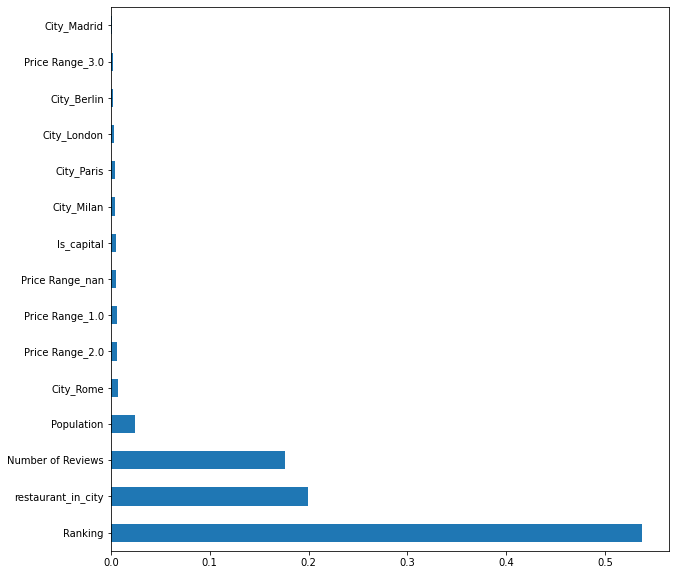

In [22]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
